# Swing Trading with Machine Learning

In [81]:
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.stats import trim_mean
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import datetime


from getData import get_data, get_ohlcv
from technical_indicator import LR, MACD, RSI, BB, ATR, ADX, RENKO, anomaly, historical_volatility, get_support_resistance_levels, VWAP
from Returns import cummulative_returns, CAGR, volatility, SHARPE, SORTINO, MAXDROWDOWN, CALMAR
from signals import stratgey1_mean_reversion

import plotly.graph_objects as go

In [94]:
ticker = 'AAPL'
data = get_data(ticker=ticker, start_date='2024-01-01')
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.290436,187.070083,182.553158,185.789453,82488700
2024-01-03,182.910522,184.528677,182.096477,182.880742,58414500
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500
...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600


In [95]:
import copy
df = copy.deepcopy(data)

In [96]:
df['m_half_50'] = df['Close'].ewm(halflife=50).mean()
df['m_half_200'] = df['Close'].ewm(halflife=200).mean()
df['m_alpha'] = df['Close'].ewm(alpha=.5).mean()
df['Distance_From_Mean'] = (df['Close'].values[:,0] - df['m_half_50'])
df

Price,Close,High,Low,Open,Volume,m_half_50,m_half_200,m_alpha,Distance_From_Mean
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2024-01-02,184.290436,187.070083,182.553158,185.789453,82488700,184.290436,184.290436,184.290436,0.000000
2024-01-03,182.910522,184.528677,182.096477,182.880742,58414500,183.595697,183.599284,183.370494,-0.685174
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600,182.579045,182.591888,181.780234,-1.991506
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300,181.885809,181.906074,180.757623,-2.022970
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500,182.363829,182.370260,182.540011,1.847170
...,...,...,...,...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600,215.770691,214.188729,202.095523,-14.320694
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600,215.589112,214.132900,202.382761,-12.919114


In [13]:
df['Distance_From_Mean'].max(), df['Distance_From_Mean'].min()

(41.35146564490208, -53.752303284212815)

In [31]:
five_pct= df['Distance_From_Mean'].max() - df['Distance_From_Mean'].max() * 0.1

In [32]:
df.loc[df['Distance_From_Mean']>=five_pct]

Price,Close,High,Low,Open,Volume,m_half_50,m_half_200,m_alpha,Distance_From_Mean
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2024-07-08,226.759537,226.789396,222.210802,226.032924,59085900,189.219768,185.554688,224.293126,37.539769
2024-07-09,227.615509,228.332159,225.316264,226.869000,48076100,189.852782,185.955878,225.954317,37.762727
2024-07-10,231.895508,231.995048,228.182875,228.232645,62627700,190.544042,186.391417,228.924913,41.351466
2024-07-12,229.466858,231.557089,227.615515,227.854404,53046500,191.760759,187.169492,228.592335,37.706099
2024-07-15,233.308884,236.125712,232.004984,235.379203,62631300,192.438524,187.599190,230.950609,40.870360
2024-07-16,233.726944,235.170191,231.248529,233.906099,43234300,193.110342,188.026281,232.338777,40.616602


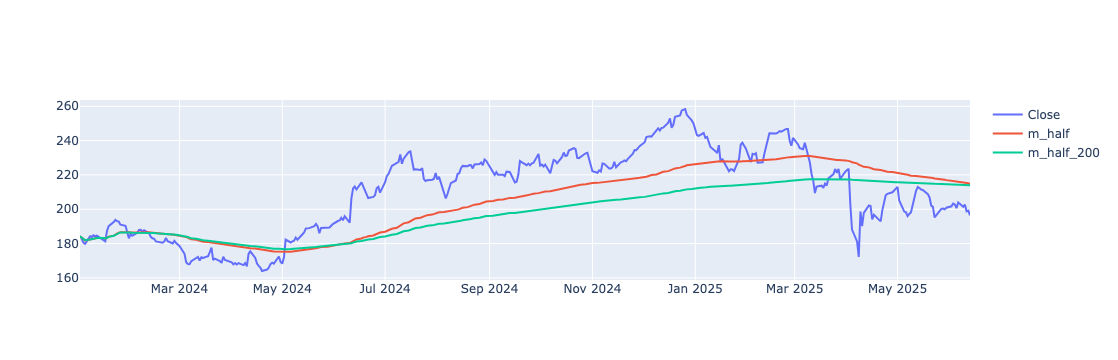

In [85]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Close'].values[:,0],
    mode='lines',  # Set the mode to 'lines' for a line chart
    name='Close'# Use the name for each line from the dictionary
))   

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['m_half_50'].values,
    mode='lines',  # Set the mode to 'lines' for a line chart
    name='m_half'# Use the name for each line from the dictionary
))   
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['m_half_200'].values,
    mode='lines',  # Set the mode to 'lines' for a line chart
    name='m_half_200'# Use the name for each line from the dictionary
))   

In [86]:
df

Price,Close,High,Low,Open,Volume,m_half_50,m_half_200,m_alpha,Distance_From_Mean
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2024-01-02,184.290436,187.070083,182.553158,185.789453,82488700,184.290436,184.290436,184.290436,0.000000
2024-01-03,182.910522,184.528677,182.096477,182.880742,58414500,183.595697,183.599284,183.370494,-0.685174
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600,182.579045,182.591888,181.780234,-1.991506
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300,181.885809,181.906074,180.757623,-2.022970
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500,182.363829,182.370260,182.540011,1.847170
...,...,...,...,...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600,215.770691,214.188729,202.095523,-14.320694
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600,215.589112,214.132900,202.382761,-12.919114


In [99]:
def label_sd_categories(df, column='Distance_From_Mean'):
    mean = df[column].mean()
    std = df[column].std()

    def categorize(x):
        if x >= mean + 3 * std:
            return 'BELOW 3 SD'
        elif x >= mean + 2 * std:
            return 'BELOW 2 SD'
        elif x >= mean + 1 * std:
            return 'BELOW 1 SD'
        elif x <= mean - 3 * std:
            return 'ABOVE 3 SD'
        elif x <= mean - 2 * std:
            return 'ABOVE 2 SD'
        elif x <= mean - 1 * std:
            return 'ABOVE 1 SD'
        else:
            return 'Beyond 1 SD'

    df['Label'] = df[column].apply(categorize)
    return df

# Preview the labeled data

label_sd_categories(df)
df

Price,Close,High,Low,Open,Volume,m_half_50,m_half_200,m_alpha,Distance_From_Mean,Label
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,
Date,,,,,,,,,,
2024-01-02,184.290436,187.070083,182.553158,185.789453,82488700,184.290436,184.290436,184.290436,0.000000,Beyond 1 SD
2024-01-03,182.910522,184.528677,182.096477,182.880742,58414500,183.595697,183.599284,183.370494,-0.685174,Beyond 1 SD
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600,182.579045,182.591888,181.780234,-1.991506,Beyond 1 SD
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300,181.885809,181.906074,180.757623,-2.022970,Beyond 1 SD
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500,182.363829,182.370260,182.540011,1.847170,Beyond 1 SD
...,...,...,...,...,...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600,215.770691,214.188729,202.095523,-14.320694,ABOVE 1 SD
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600,215.589112,214.132900,202.382761,-12.919114,ABOVE 1 SD


In [101]:
data = df

In [102]:
fig = go.Figure()
#Close
for key in df:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['Close'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='Close'# Use the name for each line from the dictionary
    ))   
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['MB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='MB'# Use the name for each line from the dictionary
    ))

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['UB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='UB'# Use the name for each line from the dictionary
    ))
    
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['LB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='LB'# Use the name for each line from the dictionary
    )) 


for level in support_levels:
    fig.add_hline(
        y=level["Close"],
        line=dict(color="green", dash="dash"),
        annotation_text=f"Support ({level['Close']})",
        annotation_position="bottom left"
    )

# Add resistance lines
for level in resistance_levels:
    fig.add_hline(
        y=level["Close"],
        line=dict(color="red", dash="dash"),
        annotation_text=f"Resistance ({level['Close']})",
                annotation_position="top left"
    )

#Buy
fig.add_trace(go.Scatter(
    x=buy.index,
    y=buy.values,
    mode='markers',
    name='Buy Signal',
    marker=dict(color='green', size=20, symbol='triangle-up')
    ))


#Sell
fig.add_trace(go.Scatter(
    x=sell.index,
    y=sell.values,
    mode='markers',
    name='Sell Signal',
    marker=dict(color='red', size=20, symbol='triangle-down')
    ))

# Customize the layout
fig.update_layout(
    title=f"{stock_name} Signal Chart",
    xaxis_title="Year",
    yaxis_title="Cumulative Return",
    autosize=False,
    width=1100,
    height=800,
    template='plotly_white'
)

fig.show()

KeyError: 'Close'